# Rock Paper Scissors


In [292]:
# uncomment when run in GoogleColab

#!pip install torchmetrics
#from google.colab import drive
#drive.mount('/content/gdrive')
#import sys
#sys.path.append('/content/gdrive/My Drive/Uni/Project Deep Learning/Shifumi_ds/myPackages')
import pytorch_toolkit

In [293]:
# Connect to Google drive, so I can import modules from it into my workspace
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = False

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "Colab Notebooks/")
    
    if os.path.exists(COLAB_NOTEBOOKS_PATH):    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        pyt_path = os.path.join(COLAB_NOTEBOOKS_PATH, 'pytorch')
        sys.path.append(pyt_path)
        print('You Pytorch Colab notebooks are available at ', pyt_path)
        print('NOTE: {} is appended to sys.path!'.format(pyt_path))
        # and test it
        import pytorch_toolkit as pyt
        MODEL_SAVE_DIR = os.path.join(pyt_path, 'model_states')
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

assert os.path.exists(MODEL_SAVE_DIR)
print('MODEL_SAVE_DIR = %s' % MODEL_SAVE_DIR)

MODEL_SAVE_DIR = ./model_states


In [294]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import glob

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook',font_scale=1.10)

# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version: %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "is NOT"))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tensorflow.keras.preprocessing.image import *
# My helper functions for training/evaluating etc.
import pytorch_toolkit as pytk

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.enabled = False

Using Pytorch version: 1.12.1. GPU is NOT available


In [295]:
CLASSES = ['rock', 'paper', 'scissors']

In [296]:
def get_data(image_paths):
    images, labels = [], []

    for image_path in image_paths:
        image = load_img(image_path, target_size=(32,32), color_mode='grayscale')
        image = img_to_array(image)
        label_name = image_path.split(os.path.sep) [-2]
        label = CLASSES.index(label_name)
        label = np.array(label).astype('int32')
        images.append(image)
        labels.append(label)

        #labels = np.expand_dims(labels, axis=0)

    return np.array(images), np.array(labels)

In [297]:
file_pattern = '/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/*/*.png'
dataset_paths = [*glob.glob(str(file_pattern))]
random.shuffle(dataset_paths)
images, labels = get_data(dataset_paths)
print(f"images.shape: {images.shape} - labels.shape: {labels.shape}")

images.shape: (7578, 32, 32, 1) - labels.shape: (7578,)


In [298]:
dataset_paths[:10]

['/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/scissors/2__3n4i3lKB3nZOpDVv.png',
 '/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/scissors/3__scissors02-019.png',
 '/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/paper/0__glu_237.png',
 '/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/paper/2__QVIiXr87PkeldzZM.png',
 '/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/scissors/2__55yz6JI9f5DTbq9D.png',
 '/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/rock/2__N235Vnlue0M9SwaK.png',
 '/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/paper/0__glu_183.png',
 '/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/rock/0__glu_44.png',
 '/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/rock/2__xy6EzMBW1U0aWDhr.png',
 '/Users/amling/uni/shifumi/DataEng/datasets/combined/combined/rock/3__rock03-113.png']

In [299]:
np.bincount(labels.astype('int32')), labels[:10]

(array([2528, 2490, 2560]), array([2, 2, 1, 1, 2, 0, 1, 0, 0, 0], dtype=int32))

In [300]:
def create_model(activate_dropout = True, dropout_probability = 0.4):
    if activate_dropout:
        net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=1), # 20
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Dropout(dropout_probability),

            nn.Conv2d(32, 64, kernel_size=5, padding=1), # 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(dropout_probability),

            nn.Conv2d(64, 64, kernel_size=5, padding=1), # 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(dropout_probability),

            nn.Flatten(),

            nn.Linear(64*2*2, 500),
            nn.ReLU(),
            nn.Dropout(dropout_probability),

            nn.Linear(500, 3)
            )
    else:
        net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=1), # 20
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=5, padding=1), # 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 64, kernel_size=5, padding=1), # 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),

            nn.Flatten(),

            nn.Linear(64*2*2, 500),
            nn.ReLU(),

            nn.Linear(500, 3)
            )

    model = pytk.PytkModuleWrapper(net)
    # add weights to optimizer due to class imbalance
    # weights = torch.FloatTensor(class_counts) / total
    # weights = weights.cuda() if torch.cuda.is_available() else weights.cpu()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=0.001)
    #optimizer = optim.SGD(params=model.parameters(), lr=0.001)
    model.compile(loss=criterion, optimizer=optimizer, metrics=['acc'])
    return model

In [301]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, activate_dropout=True, dropout_probability=0.5):
        super(MyModel, self).__init__()

        self.activate_dropout = activate_dropout
        self.dropout_probability = dropout_probability

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)
        self.dropout1 = nn.Dropout(self.dropout_probability)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout2 = nn.Dropout(self.dropout_probability)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2,2)
        self.dropout3 = nn.Dropout(self.dropout_probability)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*2*2, 500)
        self.dropout4 = nn.Dropout(self.dropout_probability)
        self.fc2 = nn.Linear(500, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.bn1(x)
        x = self.pool1(x)
        if self.activate_dropout:
            x = self.dropout1(x)

        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.bn2(x)
        x = self.pool2(x)
        if self.activate_dropout:
            x = self.dropout2(x)

        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.bn3(x)
        x = self.pool3(x)
        if self.activate_dropout:
            x = self.dropout3(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = nn.ReLU()(x)
        if self.activate_dropout:
            x = self.dropout4(x)

        x = self.fc2(x)
        return x


In [302]:
from sklearn.model_selection import train_test_split

# split dataset into train/test sets in 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, 
                                                    random_state=SEED, stratify=labels)
# split the test set into cross-val & test datasets in 80:20 rstio
# NOTE: Andrew Ng recommends that, if possible, the test & cv datasets should be drawn
# from the same sample
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, 
                                                random_state=SEED, stratify=y_test)

print(f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - class dist: {np.bincount(y_train)}\n" +
      f"X_val.shape: {X_val.shape} - y_val.shape: {y_val.shape} - class dist: {np.bincount(y_val)}\n" +
      f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape} - class dist: {np.bincount(y_test)}") 

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_val = y_val.astype('float32')

X_train.shape: (5304, 32, 32, 1) - y_train.shape: (5304,) - class dist: [1769 1743 1792]
X_val.shape: (1591, 32, 32, 1) - y_val.shape: (1591,) - class dist: [531 523 537]
X_test.shape: (683, 32, 32, 1) - y_test.shape: (683,) - class dist: [228 224 231]


In [303]:
# define a dataset for Pytorch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RPSDataset(Dataset):
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = torch.LongTensor(y)
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        if self.transforms is not None:
            x = self.transforms(x)
        return x, y

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(0, shear=0.2),         # random shear 0.2
    transforms.RandomAffine(0, scale=(0.8, 1.2)),  # random zoom 0.2
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),   
    transforms.RandomVerticalFlip(),     
])
    
image_transforms = transforms.Compose([
    transforms.ToTensor()   
])

In [304]:
train_dataset = RPSDataset(X_train, y_train, train_transforms)
val_dataset = RPSDataset(X_val, y_val, image_transforms)
test_dataset = RPSDataset(X_test, y_test, image_transforms)

images.shape: (32, 1, 32, 32) - labels.shape: (32,)


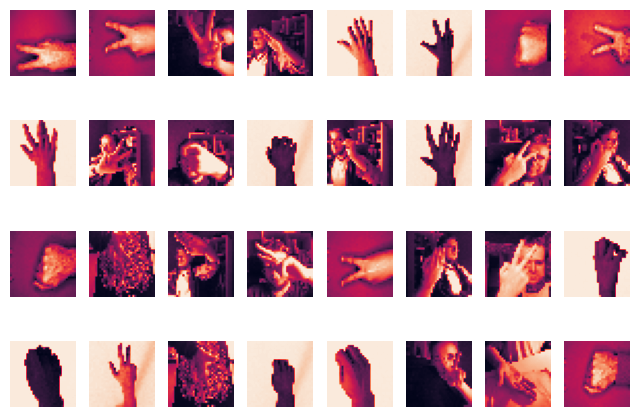

In [305]:
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
data_iter = iter(testloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    #plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image.squeeze())
    plt.axis('off')
plt.show()
plt.close()

images.shape: (32, 1, 32, 32) - labels.shape: (32,)


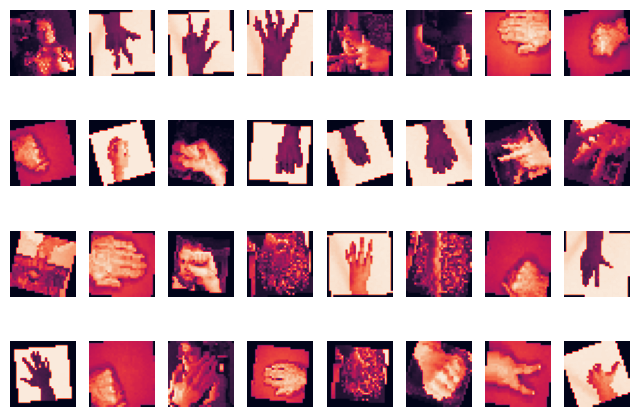

In [306]:
testloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data_iter = iter(testloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    #plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image.squeeze())
    plt.axis('off')
plt.show()
plt.close()

In [310]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model, loss function, and optimizer
model = MyModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validationloader = DataLoader(val_dataset, batch_size=64, shuffle=True)


# Loop over the data iterator and update the model
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1} loss: {running_loss / len(trainloader)}')
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in validationloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy of the network on the validation set: {100 * correct / total}%')



def test_accuracy(testloader):
    # Test the model on the test dataset
    with torch.no_grad():
        correct = 0
        total = 0
        class_correct = [0. for i in range(3)]
        class_total = [0. for i in range(3)]
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(32):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
        print(f'Accuracy of the network on the test set: {100 * correct / total}%')
        for i in range(3):
            print(f'Accuracy of {CLASSES[i]} : {100 * class_correct[i] / class_total[i]}%')

# Define the test dataloader
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print('testing against the test dataset')
test_accuracy(testloader)


print('testing against the unknwon dataset')
file_pattern_unknown_images = f'/Users/amling/uni/shifumi/DataEng/datasets/xAI-Proj-M-validation_set_pp_01_grey/{x}/*.png'
dataset_paths_unknown_images = [*glob.glob(str(file_pattern_unknown_images))]
images_unknown, labels_unknown = get_data(dataset_paths_unknown_images)
unknown_ds = RPSDataset(images_unknown, labels_unknown, train_transforms)
test_accuracy(DataLoader(unknown_ds, batch_size=64, shuffle=False))

Epoch 1 loss: 1.1002069560878247
Accuracy of the network on the validation set: 48.711502199874296%
Epoch 2 loss: 0.9114789876593165
Accuracy of the network on the validation set: 61.53362664990572%
Epoch 3 loss: 0.8184448380068124
Accuracy of the network on the validation set: 67.44186046511628%
Epoch 4 loss: 0.7333535591521895
Accuracy of the network on the validation set: 69.76744186046511%
Epoch 5 loss: 0.6811602966613081
Accuracy of the network on the validation set: 71.21307353865494%
Epoch 6 loss: 0.6577229869652943
Accuracy of the network on the validation set: 71.40163419233187%
Epoch 7 loss: 0.6213961556015244
Accuracy of the network on the validation set: 73.2872407291012%
Epoch 8 loss: 0.6177079541137419
Accuracy of the network on the validation set: 72.59585166561911%
Epoch 9 loss: 0.5894897443702422
Accuracy of the network on the validation set: 74.60716530483973%
Epoch 10 loss: 0.5793261054050491
Accuracy of the network on the validation set: 75.29855436832182%
Epoch 11 

ZeroDivisionError: float division by zero

In [ ]:
MODEL_SAVE_PATH = './model_states/pytk_rock_paper_scissors_100epoches.pt'
#model.save(MODEL_SAVE_PATH)

## Evaluation

now there comes the evaluation part

In [ ]:
pytk.show_plots(hist, metric='acc', plot_title='Model Performance')

In [ ]:
loss, acc = model.evaluate_dataset(train_dataset)
print(f"Training  -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = model.evaluate_dataset(val_dataset)
print(f"Cross-val -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = model.evaluate_dataset(test_dataset)
print(f"Testing   -> loss: {loss:.3f} - acc: {acc:.3f}")

In [ ]:
for x in ['rock','paper','scissors','*']:
    file_pattern_unknown_images = f'/Users/amling/uni/shifumi/DataEng/datasets/xAI-Proj-M-validation_set_pp_01_grey/{x}/*.png'
    dataset_paths_unknown_images = [*glob.glob(str(file_pattern_unknown_images))]
    images_unknown, labels_unknown = get_data(dataset_paths_unknown_images)
    unknown_ds = RPSDataset(images_unknown, labels_unknown, train_transforms)
    loss, acc = model.evaluate_dataset(unknown_ds)
    print(f"Testing  {x} -> loss: {loss:.3f} - acc: {acc:.3f}")